# work flow on ZTF IIb objects

### import packages

In [4]:
import sys
sys.path.append('../sdapy')
from ztfanalysis import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.cosmology import Planck13 as cosmo
from filters import *
plt.rcParams["text.usetex"] = False

In [28]:
def shock_fit(times, Me, Re, Ee):
    t = times * 86400.
    E = Ee * 1e51  
    M_sun=1.989e33
    R_sun=696340e5
    c=3.e10
    M = Me * M_sun
    R = Re * R_sun
    
    n = 10
    delta = 1.1
    K = (n-3) * (3-delta) / (4 * np.pi * (n-delta)) # K = 0.119
    kappa = 0.2 # Motivated by the helium-rich composition of this event
                # normally for Ibc we use 0.07
    vt = ((n-5) * (5-delta) / ((n-3) * (3-delta)))**0.5 * (2 * E / M)**0.5
    td = (3 * kappa * K * M / ((n-1) * vt * c))**0.5 # in second    
    prefactor = np.pi*(n-1)/(3*(n-5)) * c * R * vt**2 / kappa 
    L1 = prefactor * (td/t)**(4/(n-2))
    L2 = prefactor * np.exp(-0.5 * ((t/td)**2 - 1))
    Ls = np.zeros(len(t))
    ix1 = t < td
    Ls[ix1] = L1[ix1]
    Ls[~ix1] = L2[~ix1]
    return Ls
def shock_fit_texp(times, Me, Re, Ee, texp):
    return shock_fit(times-texp, Me, Re, Ee)

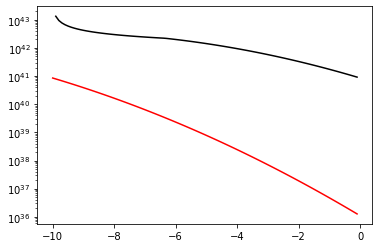

In [30]:
fig,ax=plt.subplots(1,1)
texp = -10
t = np.arange(0,10,1e-1)
l = shock_fit(t, .14, 205, 5.2e-2)
l1 = shock_fit_texp(t, .14, 205, 5.2e-2, texp)
#l = shock_fit(t, .03, 141, 9.3e-2)
ax.plot(t+texp, l, 'k-')
ax.plot(t+texp, l1, 'r-')
#ax.set_xscale('log')
ax.set_yscale('log')

In [84]:
dict()

{}

### ZTF names for the project

In [2]:
snlist = ['ZTF21abjyiiw', 'ZTF21aaabwfu']

### fun ztfmultiple to parse meta from bts catalog

In [3]:
ztfpm = ztfmultiple(metafile='rcf_query.txt', 
                    datafile='%s_data.clf',
                    parfile='priors.txt',
                    datadir='/Users/yash0613/Desktop/singleobj_study/ztficbl/',
                    skiprows=[], )
ztfpm.parse_meta(syntax='ZTFID in %s'%snlist)
ztfpm.format_meta()  

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


meta 2 objs


here


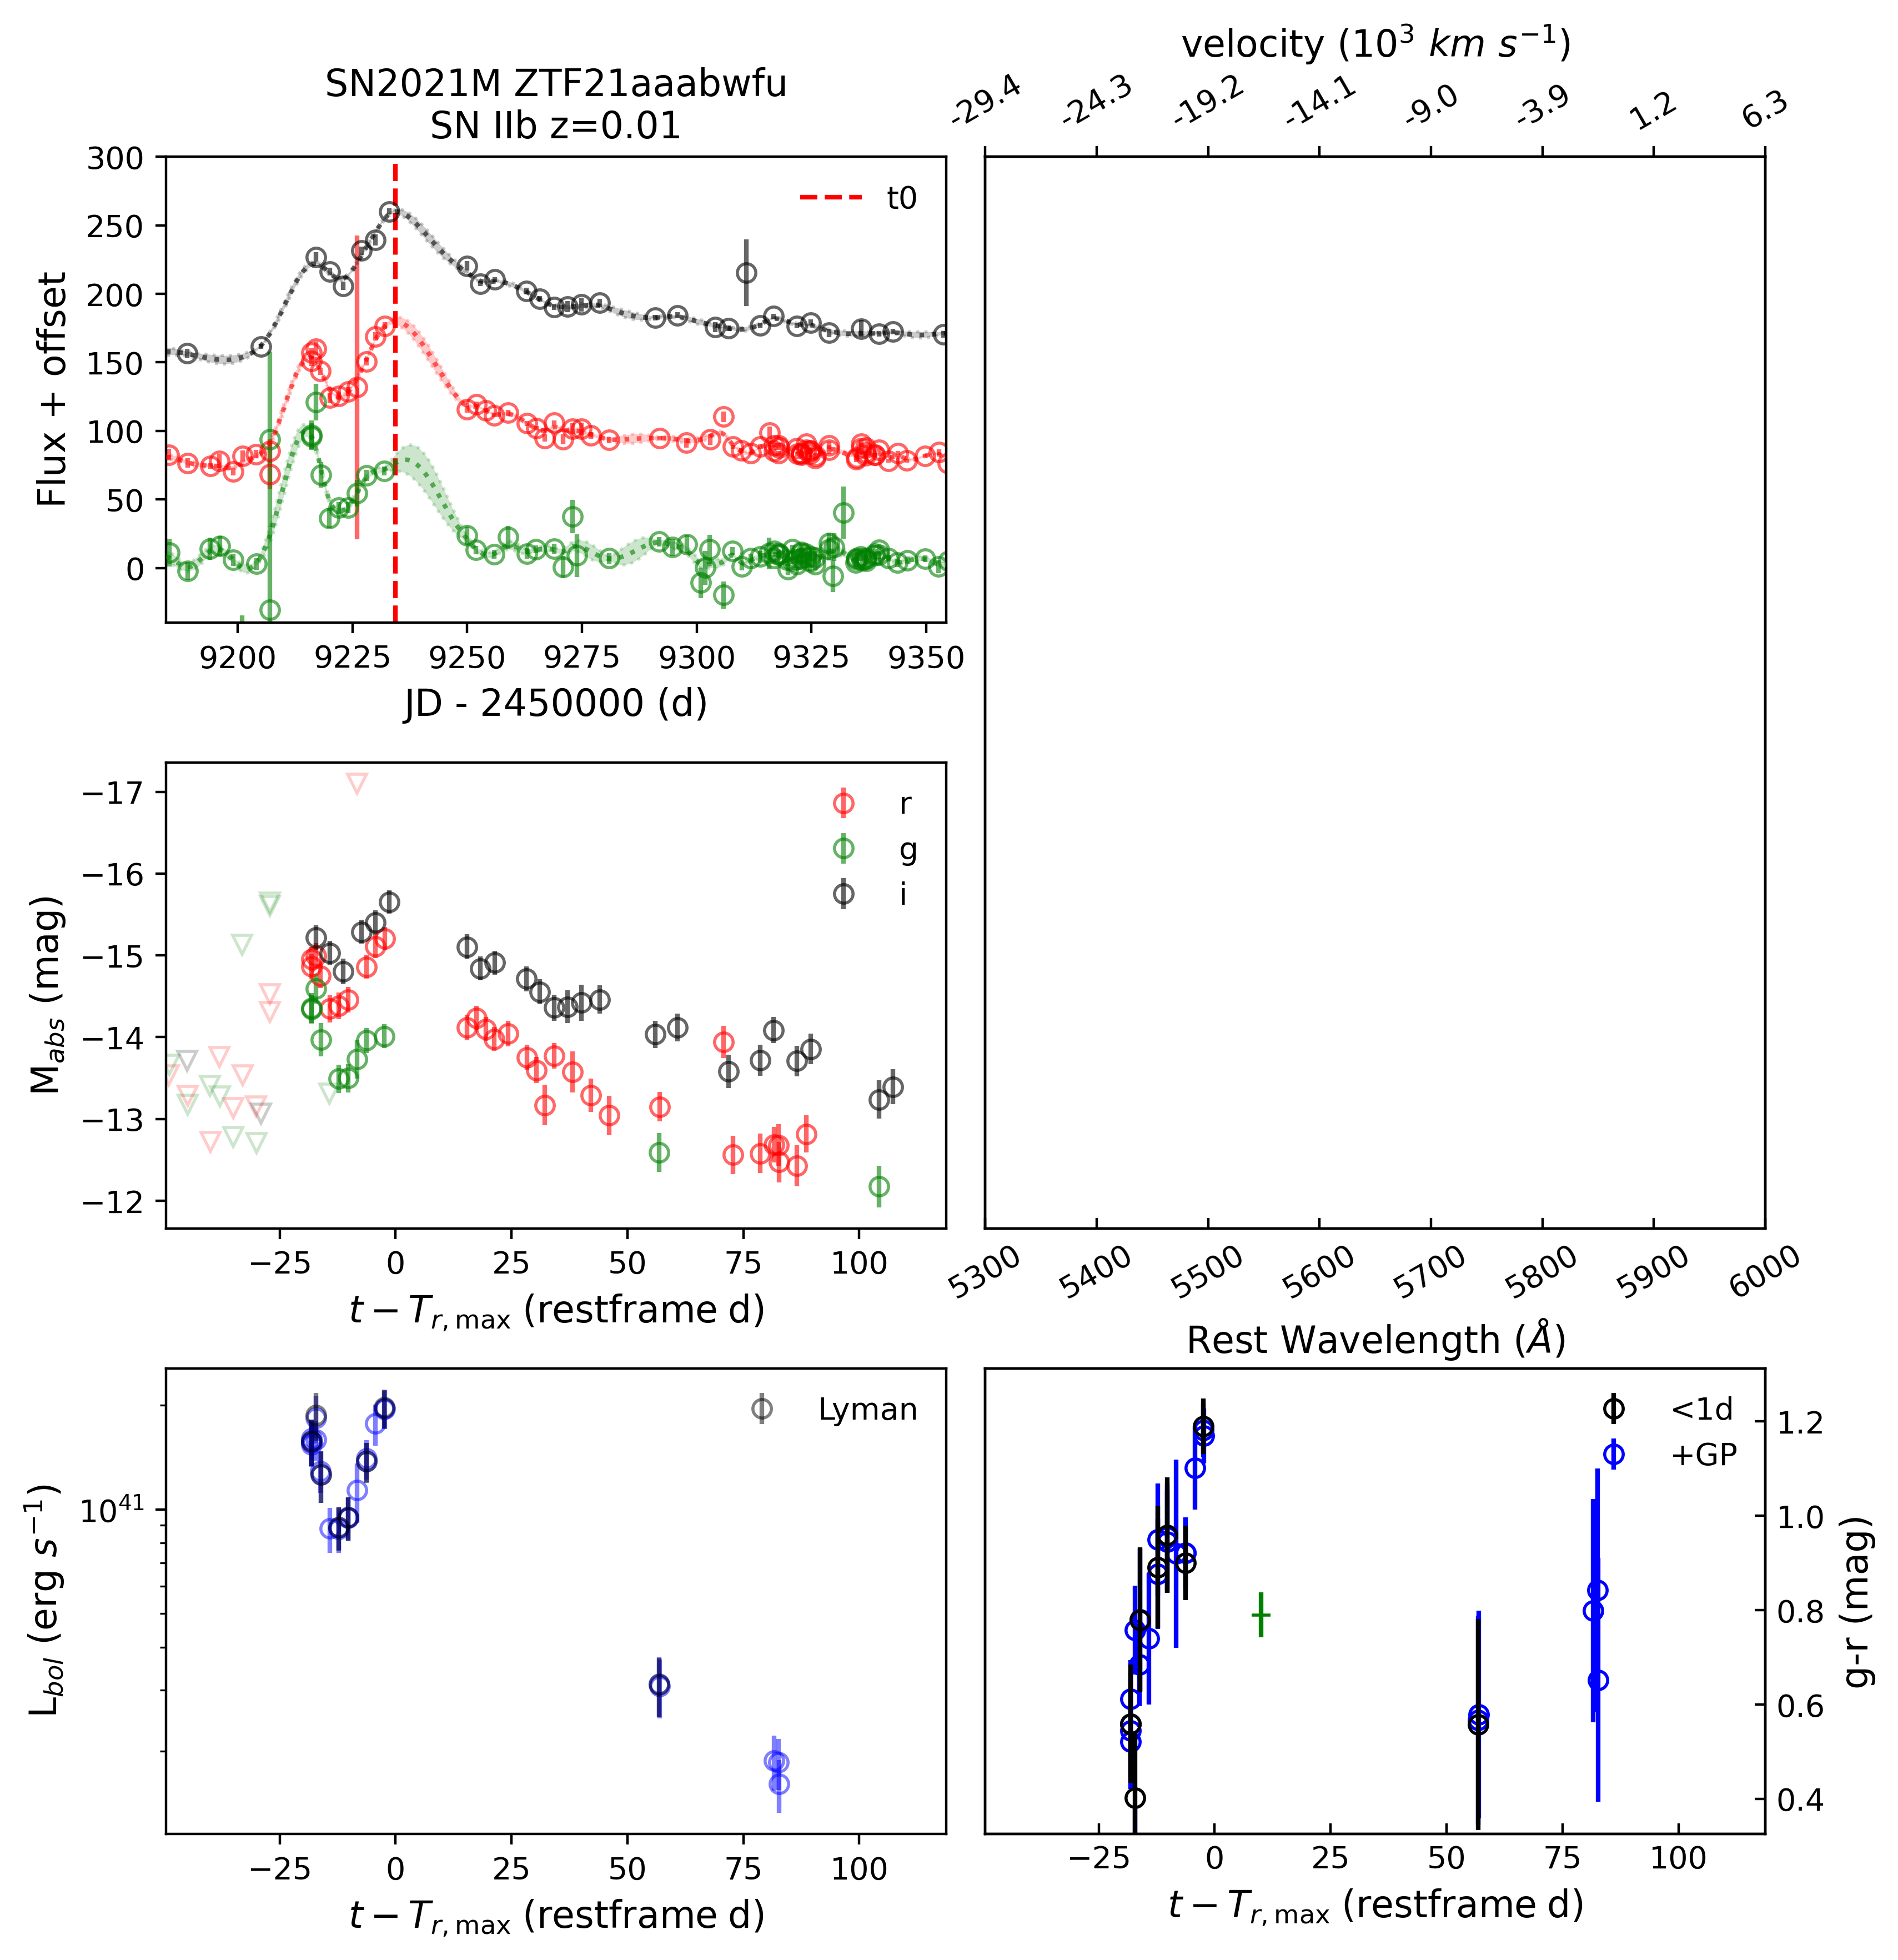

In [29]:
par = {
    'plot_bands': ['r','g','i', 'c','o'],
    'ax_xlim': [-50,120],
    'ax_ylim': [-40,300],
    'pl_type': 0,
    'pl_bands': ['o','r','g', 'i'],
    'nsteps': 40000,
    'nsteps_burnin': 20000,
    'rel_flux_cutoff': .4,
    'verbose': True,
    'nwalkers'  : 50,
    'tm_pl': 100,
    'sigma': 5,
    'shock_type': 1,
    #'gp_fitr': [-100,100],
    #'gp_plotr': [-100,100],
}
nsn=0
ztfp = ztfsingle(ztfid=ztfpm.meta.iloc[nsn]._name, iauid=ztfpm.meta.iloc[nsn]['IAUID'], 
                 z=ztfpm.meta.iloc[nsn]['redshift'], dm=ztfpm.meta.iloc[nsn]['dm'], 
                 mkwebv=ztfpm.meta.iloc[nsn]['ebv'], sntype=ztfpm.meta.iloc[nsn]['type'], 
                 ra=ztfpm.meta.iloc[nsn]['RA'], dec=ztfpm.meta.iloc[nsn]['Dec'], 
                 jdpeak=ztfpm.meta.iloc[nsn]['peakt']+2458000, **par)

if False:
    ztfp.query_fp_atlas(wdir='/Users/yash0613/Desktop/scripts/sn_data_analysis/sdapy/',
                    clobber=True, verbose=True, mjdstart=59100, mjdend=59400)
if True:
    ztfp.get_fp_ztf()
    #ztfp.get_fp_atlas(binDays=1, clobber=False, verbose=True)
    ztfp.run_gp()
    ztfp.set_t0_withgp() 
    #ztfp.set_texp_midway()
    if False:
        fig,ax=plt.subplots(1,1)
        ztfp.calibrate_baseline(ax=ax, key='fcqfid', source='ztffp',
                    xmin=-100, xmax=-20, ax_xlim=[250,300], ax_ylim=None)
    if True:
        ztfp.init_fig()
        #ztfp.explosion_pl(ext_filt=['r','g','i','o'],ext_num=10)
        ztfp.on_sntype()
        ztfp.calc_colors()
        ztfp.est_host_c10()
        ztfp.lyman_bol()
        ztfp.shock_fit()
        ztfp.plot()

In [31]:
ztfp.hostebv

0.33034546981342294